In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
import numpy as np
import pandas as pd
import scanpy as sc
import hexagdly
import os
import math
import data_processing
import argparse
import matplotlib.pyplot as plt

In [2]:
def data_processing(data_path, file_nums, k):
    # labels = []
    nums = file_nums
    features = np.zeros((len(nums), k, 64, 78))
    for i in range(len(nums)):
        print(f'processing no. {nums[i]}')
        num = nums[i]
        cells=pd.read_csv(f'{data_path}/{num}/ck17_{num}_cell_barcodes.txt')
        gene=pd.read_csv(f'{data_path}/{num}/ck17_{num}_gene_names.txt', dtype={
            'no': 'int64',
            'gene name': 'string'
        })
        meta=pd.read_csv(f'{data_path}/{num}/ck17_{num}_metadata.txt')
        if 'barcode' not in meta.columns:
            meta=meta.rename(columns={"Unnamed: 0":"barcode"})
        adata=sc.read_mtx(f'{data_path}/{num}/ck17_{num}_gex_data.txt').T
        position = pd.read_csv(f'{data_path}/{num}/ck17_{num}_tissue_positions_list.csv', names=['in_tissue', 'row', 'col', 'pixel_row', 'pixel_col'])
        position['barcode'] = position.index
        adata.obs.index=cells['x']
        adata.var.index=gene['x']
        meta.index=meta.iloc[:,0]
        adata.obs=meta
    
        adata.obs.index.name='idx'
        obs = adata.obs.merge(position[['row', 'col', 'barcode']], on='barcode', how='inner')
        # get the label: 0 for non-responder and 1 for responder
        # if obs['ici_response'].unique().item() == 'NR':
        #     labels.append(0)
        # else:
        #     labels.append(1)

        # get geneswith k-largest normalized gex
        gex_filter = np.asarray(np.sum(adata.X.todense()>0,axis=0)/2261)
        gene_no = np.argpartition(gex_filter, len(gex_filter) - k)
        gex_total = np.asarray(adata.X.todense())
    
        for j in range(k):
            for idx, row in obs.iterrows():
                hex_row = row['row']
                hex_col = row['col']
                mat_col = hex_row
                mat_row = math.floor(hex_col/2)
                features[i][j][mat_row][mat_col] = gex_total[idx][gene_no[0][-k:][j]]

    return features

In [3]:
def to_dataloader(features, labels, batch_size=2):
    data = torch.tensor(features, dtype=torch.float32)
    labels = np.asarray(labels)
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    train_data, val_data = data[:7], data[7:]
    train_labels, val_labels = labels[:7], labels[7:]
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [19]:
class hex_model(nn.Module):
    def __init__(self, nin):          
        super(hex_model, self).__init__()
        self.name = 'hex_model'
        self.hexconv1 = hexagdly.Conv2d(in_channels = nin, out_channels = 128, \
                                         kernel_size = 2, stride = 1, bias=True)
        self.hexpool1 = hexagdly.MaxPool2d(kernel_size = 2, stride = 2)
        self.hexconv2 = hexagdly.Conv2d(128, 64, 2, 1, bias=True)
        self.hexpool2 = hexagdly.MaxPool2d(kernel_size = 2, stride = 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 32 * 39, 512)
        self.fc2 = nn.Linear(512, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.hexconv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.hexpool1(x)

        x = self.hexconv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.hexpool2(x)

        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [24]:
input_channel = 3000
features = data_processing("Visium", [5,7,12,19,21,27,208,209,1294], input_channel)
labels = [1, 0, 0, 0, 0, 1, 0, 1, 1]
train_loader, val_loader = to_dataloader(features, labels, 2)

processing no. 5
processing no. 7
processing no. 12
processing no. 19
processing no. 21
processing no. 27
processing no. 208
processing no. 209
processing no. 1294


In [28]:
# loocv
data = torch.tensor(features, dtype=torch.float32)
labels = np.asarray(labels)
labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(data, labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = hex_model(input_channel).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 40
epoch_acc = []
epoch_train_losses = []
epoch_test_losses = []

for i in range(len(dataset)-1):
    train_indices = list(range(len(dataset)))
    train_indices.pop(i)
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, [i])
    
    train_loader = DataLoader(train_subset, batch_size=2, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = hex_model(input_channel).to(device)
    criterion = nn.MSELoss()
    lr = 0.005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    fold_train_losses = []
    fold_test_losses = []
    fold_acc = []
    
    for epoch in range(epochs):
        # training period
        model.train()
        training_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        fold_train_losses.append(training_loss / len(train_loader))
    
        # evaluation period
        model.eval()
        test_loss = 0
        abs_error = 0
        count_samples = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                abs_error += torch.abs(outputs - targets).sum().item()
                count_samples += targets.size(0)
        fold_test_losses.append(test_loss / len(test_loader))
        fold_acc.append(abs_error / count_samples)
        print(f'Fold {i+1}, Epoch {epoch+1}, Train Loss: {fold_train_losses[-1]}, Test Loss: {fold_test_losses[-1]}, MAE: {fold_acc[-1]}')

    epoch_train_losses.append(fold_train_losses)
    epoch_test_losses.append(fold_test_losses)
    epoch_acc.append(fold_acc)

mean_epoch_train_losses = np.mean(epoch_train_losses, axis=0)
mean_epoch_test_losses = np.mean(epoch_test_losses, axis=0)
mean_epoch_acc = np.mean(epoch_acc, axis=0)

/home/hdlab/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/hdlab/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold 1, Epoch 1, Train Loss: 6040.574393562973, Test Loss: 13031531.0, MAE: 3609.921142578125
Fold 1, Epoch 2, Train Loss: 44426.296295166016, Test Loss: 3533590.5, MAE: 1879.78466796875
Fold 1, Epoch 3, Train Loss: 25628.229125976562, Test Loss: 106335.1640625, MAE: 326.0907287597656
Fold 1, Epoch 4, Train Loss: 14569.615020751953, Test Loss: 44432.7890625, MAE: 210.79086303710938
Fold 1, Epoch 5, Train Loss: 1255.1486434936523, Test Loss: 8008.1171875, MAE: 89.48808288574219
Fold 1, Epoch 6, Train Loss: 2892.6866607666016, Test Loss: 256.1236572265625, MAE: 16.003864288330078
Fold 1, Epoch 7, Train Loss: 1386.938295841217, Test Loss: 36.27574920654297, MAE: 6.022935390472412
Fold 1, Epoch 8, Train Loss: 684.5604438781738, Test Loss: 4732.59423828125, MAE: 68.79385375976562
Fold 1, Epoch 9, Train Loss: 4865.189636230469, Test Loss: 1858.28466796875, MAE: 43.107826232910156
Fold 1, Epoch 10, Train Loss: 1760.3383407592773, Test Loss: 172.55616760253906, MAE: 13.136063575744629
Fold 1, 

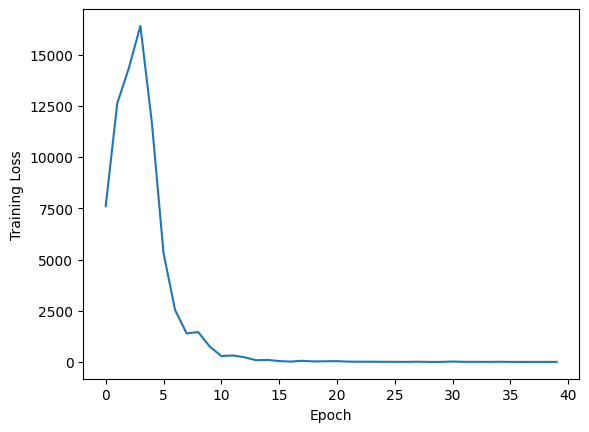

In [29]:
import matplotlib.pyplot as plt
plt.plot(mean_epoch_train_losses, label = 'Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

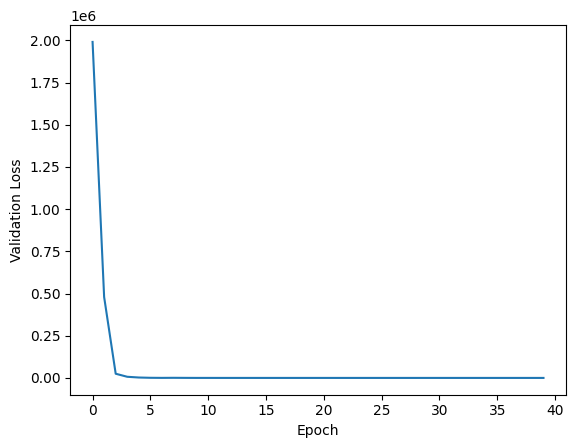

In [30]:
plt.plot(mean_epoch_test_losses, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = hex_model(input_channel).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 40
train_losses, val_losses = [], []
for epoch in range(epochs):
    # training period
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(train_loader))

    # evaluation period
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss/len(val_loader))
    
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

Epoch 1, Train Loss: 7543.828336536884, Validation Loss: 1005391.8515625
Epoch 2, Train Loss: 16741.44757080078, Validation Loss: 15001.414154052734
Epoch 3, Train Loss: 14206.288269042969, Validation Loss: 4245.108673095703
Epoch 4, Train Loss: 6840.685806274414, Validation Loss: 46920.900146484375
Epoch 5, Train Loss: 35326.82861328125, Validation Loss: 7581.148834228516
Epoch 6, Train Loss: 6492.594757080078, Validation Loss: 15136.371948242188
Epoch 7, Train Loss: 18367.773803710938, Validation Loss: 714.6603932380676
Epoch 8, Train Loss: 15420.27587890625, Validation Loss: 1745.6201934814453
Epoch 9, Train Loss: 4591.8172607421875, Validation Loss: 91.83024966716766
Epoch 10, Train Loss: 3440.7062377929688, Validation Loss: 640.2185516357422
Epoch 11, Train Loss: 59.155884742736816, Validation Loss: 417.12781524658203
Epoch 12, Train Loss: 1610.2876434326172, Validation Loss: 16.40643846988678
Epoch 13, Train Loss: 456.5457305908203, Validation Loss: 146.70013523101807
Epoch 14, T

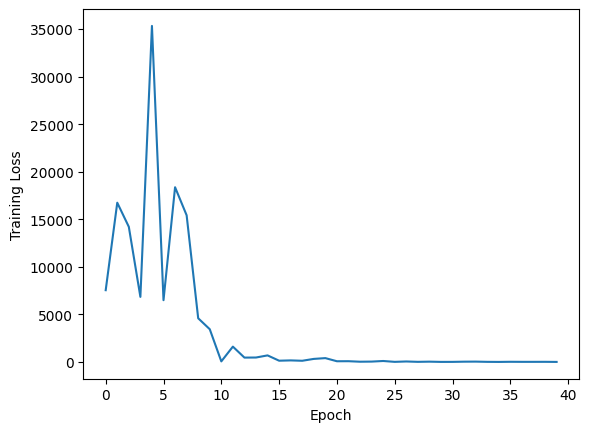

In [32]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

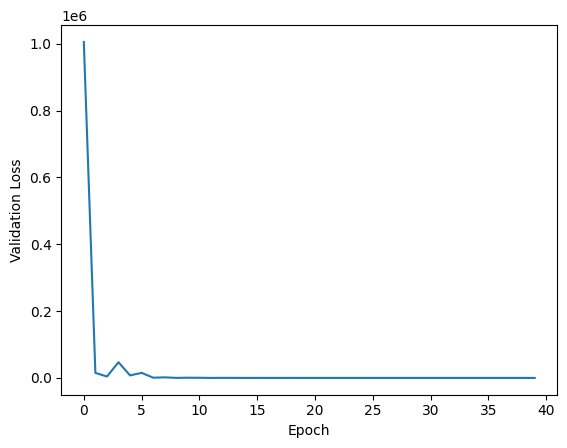

In [33]:
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()